# Use Hugging Face's Tensorflow 2 transformer models for NQ - Inference

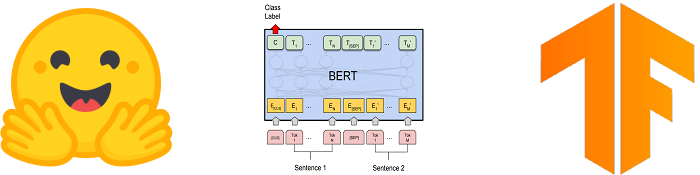

## Introduction
This inference kernel is the continuation of my TF2 training kerenl [Use Hugging Face's Tensorflow 2 transformer models for NQ](https://www.kaggle.com/yihdarshieh/use-hugging-face-s-tensorflow-2-transformer-models). These demonstrate how to use Hugging Face's [transformers](https://github.com/huggingface/transformers) package, more precisely, theier `Tensorflow 2` models, for this competition.


## Disclamation
* I am not a part of Hugging Face. I choose to use `transformers` package because I found it's easier to use and to extend, so I can focus on other parts of this notebook.
* I take no responsibility for any (potential) error in this kernel and in the dataset `nq-competition`. (I would appreciate any feedback.)
* I take no credit of any file (with/without my own modifications) containing in `nq-compeittion`.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import sys
import json
import tensorflow as tf # Yes, we are going to play with Tensorflow 2!
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import absl # For using flags without tf.compat.v1.flags.Flag
import datetime

In [ ]:
import sys
sys.path.extend(['../input/bert-joint-baseline/'])

import modeling 


In [ ]:
# Input data files are available in the "../input/" directory.
IS_KAGGLE = True
INPUT_DIR = "/kaggle/input/"

# The original Bert Joint Baseline data.
BERT_JOINT_BASE_DIR = os.path.join(INPUT_DIR, "bertjointbaseline")

# This nq dir contains all files for publicly use.
NQ_DIR = os.path.join(INPUT_DIR, "nq-competition")

# If you want to use your own .tfrecord or new trained checkpoints, you can put them under you own nq dir (`MY_OWN_NQ_DIR`)
# Default to NQ_DIR. You have to change it to the dir containing your own working files.
MY_OWN_NQ_DIR = NQ_DIR

# For local usage.
if not os.path.isdir(INPUT_DIR):
    IS_KAGGLE = False
    INPUT_DIR = "./"
    NQ_DIR = "./"
    MY_OWN_NQ_DIR = "./"

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

INPUT_DIR

In [ ]:
# NQ_DIR contains some packages / modules
sys.path.append(NQ_DIR)
sys.path.append(os.path.join(NQ_DIR, "transformers"))

from nq_flags import DEFAULT_FLAGS as FLAGS
from nq_flags import del_all_flags
from nq_dataset_utils import *

import sacremoses as sm
import transformers
from adamw_optimizer import AdamW

## Hugging Face pretrained Bert model names

In [ ]:
PRETRAINED_MODELS = {
    "BERT": [
        'bert-base-uncased',
        'bert-large-uncased',
        'bert-base-cased',
        'bert-large-cased',
        'bert-base-multilingual-uncased',
        'bert-base-multilingual-cased',
        'bert-base-chinese',
        'bert-base-german-cased',
        'bert-large-uncased-whole-word-masking',
        'bert-large-cased-whole-word-masking',
        'bert-large-uncased-whole-word-masking-finetuned-squad',
        'bert-large-cased-whole-word-masking-finetuned-squad',
        'bert-base-cased-finetuned-mrpc'
    ],
    "DISTILBERT": [
        'distilbert-base-uncased',
        'distilbert-base-uncased-distilled-squad'
    ]
}

## Abseil Flags - Datasets

In [ ]:
flags = absl.flags
del_all_flags(flags.FLAGS)

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

vocab_file = os.path.join(NQ_DIR, "vocab-nq.txt")

flags.DEFINE_string("vocab_file", vocab_file,
                    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_integer(
    "max_seq_length_for_training", 512,
    "The maximum total input sequence length after WordPiece tokenization for training examples. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "max_seq_length", 512,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_float(
    "include_unknowns_for_training", 0.02,
    "If positive, for converting training dataset, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_float(
    "include_unknowns", -1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

## Abseil Flags - Hyperparameters and file paths

In [ ]:
if os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")
elif os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")
else:
    TRAIN_TF_RECORD = os.path.join(BERT_JOINT_BASE_DIR, "nq-train.tfrecords-00000-of-00001")
    
flags.DEFINE_string("train_tf_record", TRAIN_TF_RECORD,
                    "Precomputed tf records for training dataset.")

flags.DEFINE_string("valid_tf_record", os.path.join(NQ_DIR, "nq_valid.tfrecord"),
                    "Precomputed tf records for validation dataset.")

flags.DEFINE_string("valid_small_tf_record", os.path.join(NQ_DIR, "nq_valid_small.tfrecord"),
                    "Precomputed tf records for a smaller validation dataset.")

flags.DEFINE_string("valid_tf_record_with_labels", "nq_valid_with_labels.tfrecord",
                    "Precomputed tf records for validation dataset with labels.")

flags.DEFINE_string("valid_small_tf_record_with_labels", "nq_valid_small_with_labels.tfrecord",
                    "Precomputed tf records for a smaller validation dataset with labels.")

# This file should be generated when the kernel is running using the provided test dataset!
flags.DEFINE_string("test_tf_record", "nq_test.tfrecord",
                    "Precomputed tf records for test dataset.")

flags.DEFINE_bool("do_train", False, "Whether to run training dataset.")

flags.DEFINE_bool("do_valid", False, "Whether to run validation dataset.")

flags.DEFINE_bool("smaller_valid_dataset", True, "Whether to use the smaller validation dataset")

flags.DEFINE_bool("do_predict", True, "Whether to run test dataset.")

flags.DEFINE_string(
    "validation_prediction_output_file", "validatioin_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "validation_small_prediction_output_file", "validatioin_small_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "prediction_output_file", "predictions.json",
    "Where to print predictions for test dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "input_checkpoint_dir", os.path.join(MY_OWN_NQ_DIR, "checkpoints"),
    "The root directory that contains checkpoints to be loaded of all trained models.")

flags.DEFINE_string(
    "output_checkpoint_dir", "checkpoints",
    "The output directory where the model checkpoints will be written to.")

# If you want to use other Hugging Face's models, change this to `MY_OWN_NQ_DIR` and put the downloaded models at the right place.
flags.DEFINE_string("model_dir", NQ_DIR, "Root dir of all Hugging Face's models")

# flags.DEFINE_string("model_name", "distilbert-base-uncased-distilled-squad", "Name of Hugging Face's model to use.")
flags.DEFINE_string("model_name", "bert-base-uncased", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-large-uncased-whole-word-masking-finetuned-squad", "Name of Hugging Face's model to use.")

flags.DEFINE_integer("epochs", 1, "Total epochs for training.")

flags.DEFINE_integer("train_batch_size", 5, "Batch size for training.")

flags.DEFINE_integer("shuffle_buffer_size", 10000, "Shuffle buffer size for training.")

flags.DEFINE_integer("batch_accumulation_size", 100, "Number of batches to accumulate gradient before applying optimization.")

flags.DEFINE_float("init_learning_rate", 5e-5, "The initial learning rate for AdamW optimizer.")

flags.DEFINE_bool("cyclic_learning_rate", True, "If to use cyclic learning rate.")

flags.DEFINE_float("init_weight_decay_rate", 0.01, "The initial weight decay rate for AdamW optimizer.")

flags.DEFINE_integer("num_warmup_steps", 0, "Number of training steps to perform linear learning rate warmup.")

flags.DEFINE_integer("num_train_examples", None, "Number of precomputed training steps in 1 epoch.")

flags.DEFINE_integer("predict_batch_size", 25, "Batch size for predictions.")

# ----------------------------------------------------------------------------------------
flags.DEFINE_integer(
    "n_best_size", 20,
    "The total number of n-best predictions to generate in the "
    "nbest_predictions.json output file.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_string(
    "validation_predict_file", os.path.join(NQ_DIR, "simplified-nq-dev.jsonl"),
    "")

flags.DEFINE_string(
    "validation_predict_file_small", os.path.join(NQ_DIR, "simplified-nq-dev-small.jsonl"),
    "")

# ----------------------------------------------------------------------------------------
## Special flags - do not change

if IS_KAGGLE: 
    flags.DEFINE_string(
        "predict_file", "/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl",
        "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
else:
    flags.DEFINE_string(
        "predict_file", os.path.join(NQ_DIR, "simplified-nq-test.jsonl"),
        "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
    
if IS_KAGGLE: 
    flags.DEFINE_string(
        "sample_submission_csv", "/kaggle/input/tensorflow2-question-answering/sample_submission.csv",
        "path to sample submission csv file.")
else:
    flags.DEFINE_string(
        "sample_submission_csv", os.path.join(NQ_DIR, "sample_submission.csv"),
        "path to sample submission csv file.")    
    
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

# Make the default flags as parsed flags
FLAGS.mark_as_parsed()

In [ ]:
IS_SUBMITTING = False

test_answers_df = pd.read_csv(FLAGS.sample_submission_csv)

if IS_KAGGLE and len(test_answers_df) != 692:
    IS_SUBMITTING = True
    FLAGS.do_train = False
    FLAGS.do_valid = False
    FLAGS.do_predict = True
# FLAGS.do_valid = True

In [ ]:
print(len(test_answers_df))
print(IS_SUBMITTING)
print(FLAGS.do_train)
print(FLAGS.do_valid)
print(FLAGS.do_predict)

In [ ]:
NB_ANSWER_TYPES = 5

## Make TF record file for test dataset

In [ ]:
def jsonl_iterator(jsonl_files, to_json=False):

    for file_path in jsonl_files:
        with open(file_path, "r", encoding="UTF-8") as fp:
            for jsonl in fp:
                raw_example = jsonl
                if to_json:
                    raw_example = json.loads(jsonl)
                yield raw_example

                
# Convert test examples to tf records.
creator = TFExampleCreator(is_training=False)
nq_lines = jsonl_iterator([FLAGS.predict_file])
creator.process_nq_lines(nq_lines=nq_lines, output_tfrecord=FLAGS.test_tf_record, max_examples=0, collect_nq_features=False)

## Get Datasets from TF Record files

In [ ]:
def get_dataset(tf_record_file, seq_length, batch_size=1, shuffle_buffer_size=0, is_training=False):

    if is_training:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "start_positions": tf.io.FixedLenFeature([], tf.int64),
            "end_positions": tf.io.FixedLenFeature([], tf.int64),
            "answer_types": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "token_map": tf.io.FixedLenFeature([seq_length], tf.int64)
        }        

    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)
    
        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
                        
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t
        return example

    def select_data_from_record(record):
        
        x = {
            'unique_ids': record['unique_ids'],
            'input_ids': record['input_ids'],
            'input_mask': record['input_mask'],
            'segment_ids': record['segment_ids']
        }
        
        if not is_training:
            x['token_map'] = record['token_map']

        if is_training:
            y = {
                'start_positions': record['start_positions'],
                'end_positions': record['end_positions'],
                'answer_types': record['answer_types']
            }

            return (x, y)
        
        return x

    dataset = tf.data.TFRecordDataset(tf_record_file)
    
    dataset = dataset.map(lambda record: decode_record(record, features))
    dataset = dataset.map(select_data_from_record)
    
    if shuffle_buffer_size > 0:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size)
    
    return dataset

## Check a small batch in validation / test datasets

In [ ]:
valid_tf_record = FLAGS.valid_tf_record
if FLAGS.smaller_valid_dataset:
    valid_tf_record = FLAGS.valid_small_tf_record
    
valid_tf_record_with_labels = FLAGS.valid_tf_record_with_labels
if FLAGS.smaller_valid_dataset:
    valid_tf_record_with_labels = FLAGS.valid_small_tf_record_with_labels

train_dataset = get_dataset(FLAGS.train_tf_record,
                    seq_length=FLAGS.max_seq_length_for_training,
                    batch_size=2,
                    shuffle_buffer_size=FLAGS.shuffle_buffer_size,
                    is_training=True
                )    

validation_dataset = get_dataset(os.path.join(NQ_DIR, valid_tf_record),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

validation_dataset_with_labels = get_dataset(os.path.join(NQ_DIR, valid_tf_record_with_labels),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=True
                     )

test_dataset = get_dataset(FLAGS.test_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

# Can't use next(train_dataset)!
features, targets = next(iter(train_dataset))
print(features)
print(targets)

features = next(iter(validation_dataset))
print(features)

features, labels = next(iter(validation_dataset_with_labels))
print(features)

features = next(iter(test_dataset))
print(features)

## Get the actual validation / test datasets from TF Records

In [ ]:
validation_dataset = get_dataset(os.path.join(NQ_DIR, valid_tf_record),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=FLAGS.predict_batch_size,
                         is_training=False
                     )

validation_dataset_with_labels = get_dataset(os.path.join(NQ_DIR, valid_tf_record_with_labels),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=FLAGS.predict_batch_size,
                         is_training=True
                     )

test_dataset = get_dataset(FLAGS.test_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=FLAGS.predict_batch_size,
                         is_training=False
                     )

## Get validation / test features

In [ ]:
# r is a string Tensor, we use r.numpy() to get underlying byte string
validation_features = (tf.train.Example.FromString(r.numpy()) for r in tf.data.TFRecordDataset(valid_tf_record))
test_features = (tf.train.Example.FromString(r.numpy()) for r in tf.data.TFRecordDataset(FLAGS.test_tf_record))

## An interface  for NQ models

In [ ]:
from transformers import BertTokenizer
from transformers import TFBertModel, TFDistilBertModel
from transformers import TFBertMainLayer, TFDistilBertMainLayer, TFBertPreTrainedModel, TFDistilBertPreTrainedModel
from transformers.modeling_tf_utils import get_initializer

class TFNQModel:
    
    def __init__(self, config, *inputs, **kwargs):
        """
        
        Subclasses of this class are different in self.backend,
        which should be a model that outputs a tensor of shape (batch_size, hidden_dim), and the
        `backend_call()` method.
        
        We will use Hugging Face Bert/DistilBert as backend in this notebook.
        """

        self.backend = None
        
        self.seq_output_dropout = tf.keras.layers.Dropout(kwargs.get('seq_output_dropout_prob', 0.05))
        self.pooled_output_dropout = tf.keras.layers.Dropout(kwargs.get('pooled_output_dropout_prob', 0.05))
        
        self.pos_classifier = tf.keras.layers.Dense(2,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='pos_classifier')       

        self.answer_type_classifier = tf.keras.layers.Dense(NB_ANSWER_TYPES,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='answer_type_classifier')         
                
    def backend_call(self, inputs, **kwargs):
        """This method should be implemented by subclasses.
           
           The implementation should take into account the (somehow) different input formats of Hugging Face's
           models.
           
           For example, the `TFDistilBert` model, unlike `Bert` model, doesn't have segment_id as input.
           
           Then it calls `self.backend_call()` to get the outputs from Bert's model, which is used in self.call().
        """
        
        raise NotImplementedError

    
    def call(self, inputs, **kwargs):
        
        # sequence / [CLS] outputs from original bert
        sequence_output, pooled_output = self.backend_call(inputs, **kwargs)  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        # dropout
        sequence_output = self.seq_output_dropout(sequence_output, training=kwargs.get('training', False))
        pooled_output = self.pooled_output_dropout(pooled_output, training=kwargs.get('training', False))
        
        pos_logits = self.pos_classifier(sequence_output)  # shape = (batch_size, seq_len, 2)
        start_pos_logits = pos_logits[:, :, 0]  # shape = (batch_size, seq_len)
        end_pos_logits = pos_logits[:, :, 1]  # shape = (batch_size, seq_len)
        
        answer_type_logits = self.answer_type_classifier(pooled_output)  # shape = (batch_size, NB_ANSWER_TYPES)

        outputs = (start_pos_logits, end_pos_logits, answer_type_logits)

        return outputs  # logits
    
    
class TFBertForNQ(TFNQModel, TFBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.bert = TFBertMainLayer(config, name='bert')
        
    def backend_call(self, inputs, **kwargs):
        
        outputs = self.bert(inputs, **kwargs)
        sequence_output, pooled_output = outputs[0], outputs[1]  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
        
class TFDistilBertForNQ(TFNQModel, TFDistilBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFDistilBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.backend = TFDistilBertMainLayer(config, name="distilbert")
        
    def backend_call(self, inputs, **kwargs):
        
        if isinstance(inputs, tuple):
            # Distil bert has no segment_id (i.e. `token_type_ids`)
            inputs = inputs[:2]
        else:
            inputs = inputs
        
        outputs = self.backend(inputs, **kwargs)
        
        # TFDistilBertModel's output[0] is of shape (batch_size, sequence_length, hidden_size)
        # We take only for the [CLS].
        
        sequence_output = outputs[0]  # shape = (batch_size, seq_len, hidden_dim)
        pooled_output = sequence_output[:, 0, :]  # shape = (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
    
    
model_mapping = {
    "bert": TFBertForNQ,
    "distilbert": TFDistilBertForNQ
}


def get_pretrained_model(model_name):
    
    pretrained_path = os.path.join(FLAGS.model_dir, model_name)
    
    tokenizer = BertTokenizer.from_pretrained(pretrained_path)
    
    model_type = model_name.split("-")[0]
    if model_type not in model_mapping:
        raise ValueError("Model definition not found.")
    
    model_class = model_mapping[model_type]
    model = model_class.from_pretrained(pretrained_path)
    
    return tokenizer, model

## Try Bert / DistillBert models for NQ

In [ ]:
bert_tokenizer, bert_for_nq = get_pretrained_model('bert-base-uncased')
_, distil_bert_for_nq = get_pretrained_model('distilbert-base-uncased-distilled-squad')

input_ids = tf.constant(bert_tokenizer.encode("Hello, my dog is cute"))[None, :]  # Batch size 1
input_masks = tf.constant(0, shape=input_ids.shape)
segment_ids = tf.constant(0, shape=input_ids.shape)

# Actual inputs to model
inputs = (input_ids, input_masks, segment_ids)

# Outputs from bert_for_nq using backend_call()
outputs = bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)

len(bert_for_nq.trainable_variables)

# Outputs from distil_bert_for_nq using backend_call()
outputs = distil_bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)

len(distil_bert_for_nq.trainable_variables)

### Bert Joint Baseline

In [ ]:
class TDense(tf.keras.layers.Layer):
    def __init__(self,
                 output_size,
                 kernel_initializer=None,
                 bias_initializer="zeros",
                **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
    def build(self,input_shape):
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
        if not (dtype.is_floating or dtype.is_complex):
            raise TypeError("Unable to build `TDense` layer with "
                          "non-floating point (and non-complex) "
                          "dtype %s" % (dtype,))
        input_shape = tf.TensorShape(input_shape)
        if tf.compat.dimension_value(input_shape[-1]) is None:
            raise ValueError("The last dimension of the inputs to "
                           "`TDense` should be defined. "
                           "Found `None`.")
        last_dim = tf.compat.dimension_value(input_shape[-1])
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=3, axes={-1: last_dim})
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.output_size,last_dim],
            initializer=self.kernel_initializer,
            dtype=self.dtype,
            trainable=True)
        self.bias = self.add_weight(
            "bias",
            shape=[self.output_size],
            initializer=self.bias_initializer,
            dtype=self.dtype,
            trainable=True)
        super(TDense, self).build(input_shape)
    def call(self,x):
        return tf.matmul(x,self.kernel,transpose_b=True)+self.bias
    
def mk_model(config):
    seq_len = config['max_position_embeddings']
    # unique_id  = tf.keras.Input(shape=(1,),dtype=tf.int64,name='unique_id')
    input_ids   = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_ids')
    input_mask  = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_mask')
    segment_ids = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='segment_ids')
    BERT = modeling.BertModel(config=config,name='bert')
    pooled_output, sequence_output = BERT(input_word_ids=input_ids,
                                          input_mask=input_mask,
                                          input_type_ids=segment_ids)
    
    logits = TDense(2,name='logits')(sequence_output)
    start_logits,end_logits = tf.split(logits,axis=-1,num_or_size_splits= 2,name='split')
    start_logits = tf.squeeze(start_logits,axis=-1,name='start_squeeze')
    end_logits   = tf.squeeze(end_logits,  axis=-1,name='end_squeeze')
    
    ans_type      = TDense(5,name='ans_type')(pooled_output)
    return tf.keras.Model([input_ for input_ in [input_ids,input_mask,segment_ids] 
                           if input_ is not None],
                          [start_logits,end_logits,ans_type],
                          name='bert-baseline')    

## Choose the model to use

In [ ]:
bert_tokenizer, bert_nq = get_pretrained_model(FLAGS.model_name)

In [ ]:
# bert_v2_tokenizer, bert_v2_nq = get_pretrained_model('distilbert-base-uncased-distilled-squad')

In [ ]:
# base_bert_tokenizer, base_bert_nq = get_pretrained_model('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
with open('../input/bert-joint-baseline/bert_config.json','r') as f:
    config = json.load(f)
print(json.dumps(config,indent=4))

base_bert_nq= mk_model(config)

## Try to load the latest checkpoint

In [ ]:
# # checkpoint_path = os.path.join(FLAGS.input_checkpoint_dir, FLAGS.model_name)
# checkpoint_path = os.path.join('../input/bertjointfinetuned/bert-large-uncased-whole-word-masking-finetuned-squad',
#                                'bert-large-uncased-whole-word-masking-finetuned-squad')
# # checkpoint_path = os.path.join('../input/bertjointfinetuned/bert-base-uncased-finetuned',
# #                                FLAGS.model_name)
# ckpt = tf.train.Checkpoint(model=bert_nq)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
#     print (f'Latest BertNQ checkpoint restored -- Model trained for {last_epoch} epochs')
# else:
#     print('Checkpoint not found. Train BertNQ from scratch')
#     last_epoch = 0
    
    
# # Reset saving path, because the FLAGS.input_checkpoint_dir is not writable on Kaggle
# print(ckpt_manager._directory)
# ckpt_manager._directory = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
# ckpt_manager._checkpoint_prefix = os.path.join(ckpt_manager._directory, "ckpt")
# print(ckpt_manager._directory)

# from tensorflow.python.lib.io.file_io import recursive_create_dir
# recursive_create_dir(ckpt_manager._directory)

In [ ]:
# checkpoint_path = os.path.join(FLAGS.input_checkpoint_dir, 'distilbert-base-uncased-distilled-squad')

# ckpt = tf.train.Checkpoint(model=bert_v2_nq)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
#     print (f'Latest BertNQ checkpoint restored -- Model trained for {last_epoch} epochs')
# else:
#     print('Checkpoint not found. Train BertNQ from scratch')
#     last_epoch = 0
    
    
# # Reset saving path, because the FLAGS.input_checkpoint_dir is not writable on Kaggle
# print(ckpt_manager._directory)
# ckpt_manager._directory = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
# ckpt_manager._checkpoint_prefix = os.path.join(ckpt_manager._directory, "ckpt")
# print(ckpt_manager._directory)

# from tensorflow.python.lib.io.file_io import recursive_create_dir
# recursive_create_dir(ckpt_manager._directory)

In [ ]:
# # checkpoint_path = os.path.join(FLAGS.input_checkpoint_dir, 'distilbert-base-uncased-distilled-squad')
# checkpoint_path = os.path.join('../input/bertjointfinetuned/bert-large-uncased-whole-word-masking-finetuned-squad',
#                                'bert-large-uncased-whole-word-masking-finetuned-squad')

# ckpt = tf.train.Checkpoint(model=base_bert_nq)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
#     print (f'Latest BertNQ checkpoint restored -- Model trained for {last_epoch} epochs')
# else:
#     print('Checkpoint not found. Train BertNQ from scratch')
#     last_epoch = 0
    
    
# # Reset saving path, because the FLAGS.input_checkpoint_dir is not writable on Kaggle
# print(ckpt_manager._directory)
# ckpt_manager._directory = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
# ckpt_manager._checkpoint_prefix = os.path.join(ckpt_manager._directory, "ckpt")
# print(ckpt_manager._directory)

# from tensorflow.python.lib.io.file_io import recursive_create_dir
# recursive_create_dir(ckpt_manager._directory)
# # cpkt = tf.train.Checkpoint(model=bert_nq)
# # cpkt.restore('../input/bertjointbaseline/bert_joint.ckpt').assert_consumed()

In [ ]:
bert_nq.load_weights('../input/bertjointfinetuned/bert-base-e4.h5')

In [ ]:
cpkt = tf.train.Checkpoint(model=base_bert_nq)
cpkt.restore('../input/bert-joint-baseline/model_cpkt-1').assert_consumed()

## Some methods for evaluation

In [ ]:
Span = collections.namedtuple("Span", ["start_token_idx", "end_token_idx", "score"])


class EvalExample(object):
    """Eval data available for a single example."""

    def __init__(self, example_id, candidates):
        self.example_id = example_id
        self.candidates = candidates
        self.results = {}
        self.features = {}


class ScoreSummary(object):

    def __init__(self):
        self.predicted_label = None
        self.short_span_score = None
        self.cls_token_score = None
        self.answer_type_logits = None
        self.start_prob = None
        self.end_prob = None
        self.answer_type_prob_dist = None

        
def read_candidates_from_one_split(input_path):
    """Read candidates from a single jsonl file."""
    candidates_dict = {}
    if input_path.endswith(".gz"):
        with gzip.GzipFile(fileobj=tf.io.gfile.GFile(input_path, "rb")) as input_file:
            print("Reading examples from: {}".format(input_path))
            for index, line in enumerate(input_file):
                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
                # if index > 100:
                #     break
    else:
        with tf.io.gfile.GFile(input_path, "r") as input_file:
            print("Reading examples from: {}".format(input_path))
            for index, line in enumerate(input_file):
                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
                # if index > 100:
                #     break


    return candidates_dict


def read_candidates(input_pattern):
    """Read candidates with real multiple processes."""
    input_paths = tf.io.gfile.glob(input_pattern)
    final_dict = {}
    for input_path in input_paths:
        final_dict.update(read_candidates_from_one_split(input_path))
    return final_dict


def get_best_indexes(logits, n_best_size, token_map=None):
    # Return a sorted list of (idx, logit)
    index_and_score = sorted(enumerate(logits[1:], 1), key=lambda x: x[1], reverse=True)
        
    best_indexes = []
    for i in range(len(index_and_score)):
        
        idx = index_and_score[i][0]

        if token_map is not None and token_map[idx] == -1:
            continue

        best_indexes.append(idx)

        if len(best_indexes) >= n_best_size:
            break    
    
    return best_indexes

In [ ]:
def remove_duplicates(span):
    start_end = []
    for s in span:
        cont = 0
        if not start_end:
            start_end.append(Span(s[0], s[1], s[2]))
            cont += 1
        else:
            for i in range(len(start_end)):
                if start_end[i][0] == s[0] and start_end[i][1] == s[1]:
                    cont += 1
        if cont == 0:
            start_end.append(Span(s[0], s[1], s[2]))
            
    return start_end

def get_short_long_span(predictions, example):
    
    sorted_predictions = sorted(predictions, key=lambda x: (x[0], x[2], x[3]), reverse=True)
    short_span = []
    long_span = []
    for prediction in sorted_predictions:
        score, summary, start_span, end_span = prediction
        # get scores > zero
        if score > 0:
            short_span.append(Span(int(start_span), int(end_span), float(score)))

    short_span = remove_duplicates(short_span)

    for s in range(len(short_span)):
        for c in example.candidates:
            start = short_span[s].start_token_idx
            end = short_span[s].end_token_idx

            if c["top_level"] and c["start_token"] <= start and c["end_token"] >= end:
                long_span.append(Span(int(c["start_token"]), int(c["end_token"]), float(short_span[s].score)))
                break
    long_span = remove_duplicates(long_span)
    
    if not long_span:
        long_span = [Span(-1, -1, -10000.0)]
    if not short_span:
        short_span = [Span(-1, -1, -10000.0)]
        
    
    return short_span, long_span

In [ ]:
def compute_predictions(example):
    """Converts an example into an NQEval object for evaluation.
    
       Unlike the starter kernel, this returns a list of `ScoreSummary`, sorted by score.
    """
    
    predictions = []
    max_answer_length = FLAGS.max_answer_length
    null_entry_threshold = -0.3
    score_null = 1000000


    for unique_id, result in example.results.items():
        
        if unique_id not in example.features:
            raise ValueError("No feature found with unique_id:", unique_id)
        token_map = example.features[unique_id]["token_map"].int64_list.value
        
        # feature_null_score = result["cls_start_logit"] + result["cls_end_logit"]
        feature_null_score = result["start_logits"][0] + result["end_logits"][0]
        score_null = min(score_null, feature_null_score)
        
        for start_index, start_logit, start_prob in zip(result["start_indexes"], result["start_logits"], result["start_pos_prob_dist"]):

            if token_map[start_index] == -1:
                continue            
            
            for end_index, end_logit, end_prob in zip(result["end_indexes"], result["end_logits"], result["end_pos_prob_dist"]):

                if token_map[end_index] == -1:
                    continue

                if end_index < start_index:
                    continue                    
                    
                length = end_index - start_index + 1
                if length > max_answer_length:
                    continue

                summary = ScoreSummary()
                
                summary.instance_id = unique_id
                
                summary.short_span_score = start_logit + end_logit
                summary.cls_token_score = result["cls_start_logit"] + result["cls_end_logit"]
                summary.answer_type_logits = result["answer_type_logits"]
                
                summary.start_indexes = result["start_indexes"]
                summary.end_indexes = result["end_indexes"]

                summary.start_logits = result["start_logits"]
                summary.end_logits = result["end_logits"]                
                
                summary.start_pos_prob_dist = result["start_pos_prob_dist"]
                summary.end_pos_prob_dist = result["end_pos_prob_dist"]                
                           
                summary.start_index = start_index
                summary.end_index = end_index
                
                summary.start_logit = start_logit
                summary.end_logit = end_logit
                
                answer_type_prob_dist = result["answer_type_prob_dist"]
                summary.start_prob = start_prob
                summary.end_prob = end_prob
                summary.answer_type_prob_dist = {
                    "unknown": answer_type_prob_dist[0],
                    "yes": answer_type_prob_dist[1],
                    "no": answer_type_prob_dist[2],
                    "short": answer_type_prob_dist[3],
                    "long": answer_type_prob_dist[4]
                }
                
                start_span = token_map[start_index]
                end_span = token_map[end_index] + 1

                # Span logits minus the cls logits seems to be close to the best.
                score = summary.short_span_score - summary.cls_token_score
                predictions.append((score, summary, start_span, end_span))
                
    all_summaries = []      

    short_span = [Span(-1, -1, 0)]
    long_span = [Span(-1, -1, 0)]
    score = 0
    summary = ScoreSummary() 
        
    if predictions:
        short_span, long_span = get_short_long_span(predictions, example)

    if len(all_summaries) == 0:
       
        summary.predicted_label = {
                "example_id": example.example_id,
                "instance_id": None,
                "long_answer": {
                        "tokens_and_score": long_span,
                        "start_byte": -1,
                        "end_byte": -1
                },
                "long_answer_score": score,
                "short_answers": [{
                        "tokens_and_score": short_span,
                        "start_byte": -1,
                        "end_byte": -1
                }],
                "short_answers_score": score,
                "yes_no_answer": "NONE",
                "no_answer": True
        }        
        
        all_summaries.append(summary)
            
    all_summaries = all_summaries[:min(FLAGS.n_best_size, len(all_summaries))]        
    
    return all_summaries


def compute_pred_dict(candidates_dict, dev_features, raw_results):
    """Computes official answer key from raw logits.
    
       Unlike the starter kernel, each nq_pred_dict[example_id] is a list of `predicted_label`
       that is defined in `compute_predictions`.
    """

    raw_results_by_id = [(int(res["unique_id"]), 1, res, None) for res in raw_results]

    examples_by_id = [(int(tf.cast(int(k), dtype=tf.int32)), 0, v, k) for k, v in candidates_dict.items()]
    
    features_by_id = [(int(tf.cast(f.features.feature["unique_ids"].int64_list.value[0], dtype=tf.int32)), 2, f.features.feature, None) for f in dev_features]
    
    print('merging examples...')
    merged = sorted(examples_by_id + raw_results_by_id + features_by_id)
    print('done.')
    
    examples = []
    for idx, type_, datum, orig_example_id in merged:
        if type_ == 0: # Here, datum the list `long_answer_candidates`
            examples.append(EvalExample(orig_example_id, datum))
        elif type_ == 2: # Here, datum is a feature with `token_map`
            examples[-1].features[idx] = datum
        else: # Here, datum is a raw_result given by the model
            examples[-1].results[idx] = datum    
    
    # Construct prediction objects.
    summary_dict = {}
    nq_pred_dict = {}
    for e in examples:
        
        all_summaries = compute_predictions(e)
        summary_dict[e.example_id] = all_summaries
        nq_pred_dict[e.example_id] = [summary.predicted_label for summary in all_summaries]
        if len(nq_pred_dict) % 100 == 0:
            print("Examples processed: %d" % len(nq_pred_dict))

    return nq_pred_dict

## Get logits from model - Save to a json file

In [ ]:
def get_prediction_json(mode, max_nb_pos_logits=-1):
    
    if mode == 'valid':
        dataset = validation_dataset
        if FLAGS.smaller_valid_dataset:
            predict_file = FLAGS.validation_predict_file_small
            prediction_output_file = FLAGS.validation_small_prediction_output_file
        else:
            predict_file = FLAGS.validation_predict_file
            prediction_output_file = FLAGS.validation_prediction_output_file
        eval_features = validation_features
    else:
        dataset = test_dataset
        predict_file = FLAGS.predict_file
        eval_features = test_features
        prediction_output_file = FLAGS.prediction_output_file
    
    print(predict_file)
    print(prediction_output_file)
    
    all_results = []

    prediction_start_time = datetime.datetime.now()

    for (batch_idx, features) in enumerate(dataset):

        batch_start_time = datetime.datetime.now()

        unique_ids = features['unique_ids']
        token_maps = features['token_map']       
        
        (input_ids, input_masks, segment_ids) = (features['input_ids'], features['input_mask'], features['segment_ids'])
        
        nq_inputs = (input_ids, input_masks, segment_ids)
        nq_logits = bert_nq(nq_inputs, training=False)
        
        base_nq_logits = base_bert_nq(nq_inputs, training=False)
        #distill_nq_logits = bert_v2_nq(nq_inputs, training=False)

        (start_pos_logits, end_pos_logits, answer_type_logits) = nq_logits
        (base_start_pos_logits, base_end_pos_logits, baseanswer_type_logits) = base_nq_logits
        #(distill_start_pos_logits, distill_end_pos_logits, distill_answer_type_logits) = distill_nq_logits
        
        start_pos_logits = (0.2 * start_pos_logits + 0.8 * base_start_pos_logits)
        end_pos_logits = (0.2 * end_pos_logits + 0.8 * base_end_pos_logits)
        answer_type_logits = (0.2 * answer_type_logits + 0.8 * baseanswer_type_logits)

        # start_pos_logits = (0.12 * start_pos_logits + 0.8 * base_start_pos_logits + 0.08 * distill_start_pos_logits)
        # end_pos_logits = (0.12 * end_pos_logits + 0.8 * base_end_pos_logits + 0.08 * distill_end_pos_logits)
        # answer_type_logits = (0.12 * answer_type_logits + 0.8 * baseanswer_type_logits + 0.08 * distill_answer_type_logits)
        

        unique_ids = unique_ids.numpy().tolist()
        
        token_maps = token_maps.numpy().tolist()
        
        start_pos_prob_dist = tf.nn.softmax(start_pos_logits, axis=-1).numpy().tolist()
        end_pos_prob_dist = tf.nn.softmax(end_pos_logits, axis=-1).numpy().tolist()
        answer_type_prob_dist = tf.nn.softmax(answer_type_logits, axis=-1).numpy().tolist()
        
        start_pos_logits = start_pos_logits.numpy().tolist()
        end_pos_logits = end_pos_logits.numpy().tolist()
        answer_type_logits = answer_type_logits.numpy().tolist()

        for uid, token_map, s, e, a, sp, ep, ap in zip(unique_ids, token_maps, start_pos_logits, end_pos_logits, answer_type_logits, start_pos_prob_dist, end_pos_prob_dist, answer_type_prob_dist):

            if max_nb_pos_logits < 0:
                max_nb_pos_logits = len(start_pos_logits)
            
            # full_start_logits = s
            # full_end_logits = e
            
            cls_start_logit = s[0]
            cls_end_logit = e[0]
            
            start_indexes = get_best_indexes(s, max_nb_pos_logits, token_map)
            end_indexes = get_best_indexes(e, max_nb_pos_logits, token_map)            
            
            s = [s[idx] for idx in start_indexes]
            e = [e[idx] for idx in end_indexes]
            sp = [sp[idx] for idx in start_indexes]
            ep = [ep[idx] for idx in end_indexes]            
            
            raw_result = {
                "unique_id": uid,
                "start_indexes": start_indexes,
                "end_indexes": end_indexes,
                "start_logits": s,
                "end_logits": e,
                "answer_type_logits": a,
                "start_pos_prob_dist": sp,
                "end_pos_prob_dist": ep,
                "answer_type_prob_dist": ap,
                "cls_start_logit": cls_start_logit,
                "cls_end_logit": cls_end_logit
                # "full_start_logits": full_start_logits,
                # "full_end_logits": full_end_logits
            }
            all_results.append(raw_result)

        batch_end_time = datetime.datetime.now()
        batch_elapsed_time = (batch_end_time - batch_start_time).total_seconds()

        if (batch_idx + 1) % 100 == 0:
            print('Batch {} | Elapsed Time {}'.format(
                batch_idx + 1,
                batch_elapsed_time
            ))
      
    prediction_end_time = datetime.datetime.now()
    prediction_elapsed_time = (prediction_end_time - prediction_start_time).total_seconds()

    print('\nTime taken for prediction: {} secs\n'.format(prediction_elapsed_time))
    print("-" * 80 + "\n")

    print("Going to candidates file")
    candidates_dict = read_candidates(predict_file)

    print ("setting up eval features")
    # eval_features = ...

    print ("compute_pred_dict")
    nq_pred_dict = compute_pred_dict(candidates_dict, eval_features, all_results)
    
    predictions_json = {"predictions": list(nq_pred_dict.values())}

    print ("writing json")
    with tf.io.gfile.GFile(prediction_output_file, "w") as f:
        json.dump(predictions_json, f, indent=4)
        
    return predictions_json

## Code for metrics

In [ ]:
from sklearn.metrics import f1_score

def create_answer_from_token_indices(answer):
    
    if answer["start_token"] == -1 or answer["end_token"] == -1:
        return ""
    else:
        return str(answer["start_token"]) + ":" + str(answer["end_token"])
    
def create_long_answer_from_1_pred(pred):
    """
    Args:
        pred: A `predicted_label` as defined in `compute_predictions`.
    
    Returns:
        A string. It's either an empty string "" or a string of the form "start_token:end_token",
        where start_token and end_token are string forms of integers.
    """
    if pred["long_answer_score"] < 1.5 or pred['answer_type'] == 0:
        return ""
    long_answer = create_answer_from_token_indices(pred["long_answer"])
    
    return long_answer
    
    
def create_short_answers_from_1_pred(pred):
    """
    Args:
        pred: A `predicted_label` as defined in `compute_predictions`.
    
    Returns:
        A list of strings. Each element can be [""], ["YES"], ["NO"] or an list of strings with
        the form "start_token:end_token" as describe in `create_long_answer_from_1_pred`.
    """
    
    short_answers = []
    
    for predicted_short_answer in pred["short_answers"]:
        
        short_answer = create_answer_from_token_indices(predicted_short_answer)

        # Custom
        if "answer_type_prob_dist" in pred:

            if pred["short_answers_score"] < 1.5 or pred['answer_type'] == 0:
                if short_answer not in ["YES", "NO"]:
                    short_answer = ""
    
        short_answers.append(short_answer)
    
    return short_answers


def is_pred_ok(pred, annotations):
    """
    Args:
        pred: A `predicted_label` as defined in `compute_predictions`.
        annotations: A list of annotations. See `simplified-nq-dev.jsonl` for the format.
        
    Returns:
        has_long_label: bool
        has_short_label: bool
        has_long_pred: bool
        has_short_pred: bool
        is_long_pred_correct: bool
        is_short_pred_correct: bool
    """    
        
    long_labels = []
    
    for annotation in annotations:
        
        long_label = create_answer_from_token_indices(annotation["long_answer"])
        long_labels.append(long_label)
        
    non_null_long_labels = [x for x in long_labels if x != ""]
    has_long_label = len(non_null_long_labels) > 1
    
    long_pred = create_long_answer_from_1_pred(pred)
    has_long_pred = (long_pred != "")
    
    short_label_lists = []
    
    for annotation in annotations:
        
        if len(annotation["short_answers"]) == 0:
            if annotation["yes_no_answer"] == "YES":
                short_label_lists.append(["YES"])
            elif annotation["yes_no_answer"] == "NO":
                short_label_lists.append(["NO"])
            else:
                short_label_lists.append([""])
        else:
            
            short_labels = []
            for anno_short_answer in annotation["short_answers"]:
                short_label = create_answer_from_token_indices(anno_short_answer)
                short_labels.append(short_label)
            
            short_label_lists.append(short_labels)        
    
    non_null_short_label_lists = [x for x in short_label_lists if x != [""]]
    has_short_label = len(non_null_short_label_lists) > 1
    
    # It can be [""], ["YES"], ["NO"] or ["start_token:end_token"].
    short_preds = create_short_answers_from_1_pred(pred)
    has_short_pred = (short_preds != [""])
    
    is_long_pred_correct = False
    is_short_pred_correct = False
    
    for long_label in long_labels:
        
        if has_long_label and long_label == "":
            continue
        if not has_long_label and long_label != "":
            continue
            
        if long_pred == long_label:
            is_long_pred_correct = True
            break

    for short_labels in short_label_lists:

        if has_short_label and short_labels == [""]:
            continue
        if not has_short_label and short_labels != [""]:
            continue        
            
        if has_short_label:
            
            if short_labels == ["YES"] or short_labels == ["NO"]:

                if short_preds == short_labels:
                    is_short_pred_correct = True
                    break

            else:
                if short_preds[0] in short_labels:

                    is_short_pred_correct = True
                    break
                        
        else:
            
            if short_preds == short_labels:
                is_short_pred_correct = True
                break

     
    return has_long_label, has_short_label, has_long_pred, has_short_pred, is_long_pred_correct, is_short_pred_correct


def compute_f1_scores(predictions_json, gold_jsonl_file):
    
    predictions = predictions_json["predictions"]
    
    golden_nq_lines = jsonl_iterator([gold_jsonl_file])
    golden_dict = dict()
    for nq_line in golden_nq_lines:
        nq_data = json.loads(nq_line)
        golden = dict()
        golden["example_id"] = nq_data["example_id"]
        golden["annotations"] = nq_data["annotations"]
        golden_dict[golden["example_id"]] = golden
        
    long_labels = []
    long_preds = []
    short_labels = []
    short_preds = []

    for preds in predictions:
        
        # Let's take only the 1st pred for now. We can play with multiple preds if we want.
        pred = preds[0]
        
        example_id = pred["example_id"]
        assert example_id in golden_dict
        golden = golden_dict[example_id]
        assert example_id == golden["example_id"]
        
        has_long_label, has_short_label, has_long_pred, has_short_pred, is_long_correct, is_short_correct = is_pred_ok(pred, golden["annotations"])
        
        if has_long_label or has_long_pred:
            if is_long_correct:
                long_labels.append(1)
                long_preds.append(1)
            else:
                long_labels.append(1)
                long_preds.append(0)            
        
        if has_short_label or has_short_pred:        
            if is_short_correct:
                short_labels.append(1)
                short_preds.append(1)
            else:
                short_labels.append(1)
                short_preds.append(0)
            
    f1 = f1_score(long_labels + short_labels, long_preds + short_preds)
    long_f1 = f1_score(long_labels, long_preds)
    short_f1 = f1_score(short_labels, short_preds)

    return f1, long_f1, short_f1

## Get metrics for test dataset

In [ ]:
def df_long_index_score(df):
    #print(df)
    answers = []
    cont = 0
    for e in df[0]['long_answer']['tokens_and_score']:
        # if score > 2
        if e[2] >= 1.5: 
            index = {}
            index['start'] = e[0]
            index['end'] = e[1]
            index['score'] = e[2]
            answers.append(str(index['start']) + ":" + str(index['end']))
            cont += 1
        # number of answers
        if cont == 1:
            break
    if len(answers) == 0:
        return ""
    return answers[0]

def df_short_index_score(df):
    answers = []
    cont = 0
    for e in df[0]['short_answers'][0]['tokens_and_score']:
        # if score > 2
        if e[2] >= 3.0:
            index = {}
            index['start'] = e[0]
            index['end'] = e[1]
            index['score'] = e[2]
            answers.append(str(index['start']) + ":" + str(index['end']))
            cont += 1
        # number of answers
        if cont == 1:
            break
            
    if len(answers) == 0:
        return ""
    return answers[0]

## Run on test dataset

In [ ]:
if FLAGS.do_predict:
    test_features = (tf.train.Example.FromString(r.numpy()) for r in tf.data.TFRecordDataset(FLAGS.test_tf_record))
    predictions_json = get_prediction_json(mode='test', max_nb_pos_logits=FLAGS.n_best_size)

## Submission files


The Bert model produces a confidence score, which the Kaggle metric does not use. You, however, can use that score to determine which answers get submitted. See the limits commented out in create_short_answer and create_long_answer below for an example.

Values for confidence will range between 1.0 and 2.0.

In [ ]:
def create_long_answer(preds):
    """
    Args:
        preds: A list of `predicted_label` as defined in `compute_predictions`.
    
    Returns:
        A string represented a long answer.
    """
    
    # Currently, return the long answer from the 1st pred in preds.
    return create_long_answer_from_1_pred(preds[0])  
    
    
def create_short_answer(preds):
    """
    Args:
        pred: A list of `predicted_label` as defined in `compute_predictions`.
    
    Returns:
        A string represented a short answer.
    """
    
    # Currently, return the short answer from the 1st pred in preds.
    return create_short_answers_from_1_pred(preds[0])[0]


if FLAGS.do_predict:

    test_answers_df = pd.read_json(FLAGS.prediction_output_file)

    test_answers_df["long_answer_score"] = test_answers_df["predictions"].apply(lambda q: q[0]["long_answer_score"])
    test_answers_df["short_answer_score"] = test_answers_df["predictions"].apply(lambda q: q[0]["short_answers_score"])

    test_answers_df["long_answer_score"].describe()
    
    sample_submission = pd.read_csv(FLAGS.sample_submission_csv)
    sample_submission.to_csv("submission.csv", index=False)

    # We re-format the JSON answers to match the requirements for submission.
    # test_answers_df["long_answer"] = test_answers_df["predictions"].apply(create_long_answer)
    # test_answers_df["short_answer"] = test_answers_df["predictions"].apply(create_short_answer)
    test_answers_df["long_answer"] = test_answers_df["predictions"].apply(df_long_index_score)
    test_answers_df["short_answer"] = test_answers_df["predictions"].apply(df_short_index_score)
    
    test_answers_df["example_id"] = test_answers_df["predictions"].apply(lambda q: str(q[0]["example_id"]))

    long_answers = dict(zip(test_answers_df["example_id"], test_answers_df["long_answer"]))
    short_answers = dict(zip(test_answers_df["example_id"], test_answers_df["short_answer"]))

    # Then we add them to our sample submission. Recall that each sample has both a _long and _short entry in the sample submission, one for each type of answer.

    long_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_long")].apply(lambda q: long_answers[q["example_id"].replace("_long", "")], axis=1)
    short_prediction_strings = sample_submission[sample_submission["example_id"].str.contains("_short")].apply(lambda q: short_answers[q["example_id"].replace("_short", "")], axis=1)

    sample_submission.loc[sample_submission["example_id"].str.contains("_long"), "PredictionString"] = long_prediction_strings
    sample_submission.loc[sample_submission["example_id"].str.contains("_short"), "PredictionString"] = short_prediction_strings

    # And finally, we write out our submission!
    sample_submission.to_csv("submission.csv", index=False)

In [ ]:
!ls -l

In [ ]:
df = pd.read_csv('submission.csv')
df.head()

In [ ]:
df[df['PredictionString'].isnull()].shape

In [ ]:
test_answers_df["long_answer_score"].describe()